In [1]:
from diffusers import DiffusionPipeline
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipeline.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
prompt = 'A photograph of a puppy'
# Turn the text into a sequence of tokens:
text_input = pipeline.tokenizer(prompt, padding="max_length",
                                max_length=pipeline.tokenizer.model_max_length,
                                truncation=True, return_tensors="pt")
# See the individual tokens
for t in text_input['input_ids'][0][:8]:  # We'll just look at the first 7
    print(t, pipeline.tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(8853) photograph</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [3]:
# Grab the output embeddings
text_embeddings = pipeline.text_encoder(text_input.input_ids.to(device))[0]
print('Text embeddings shape:', text_embeddings.shape)

Text embeddings shape: torch.Size([1, 77, 768])


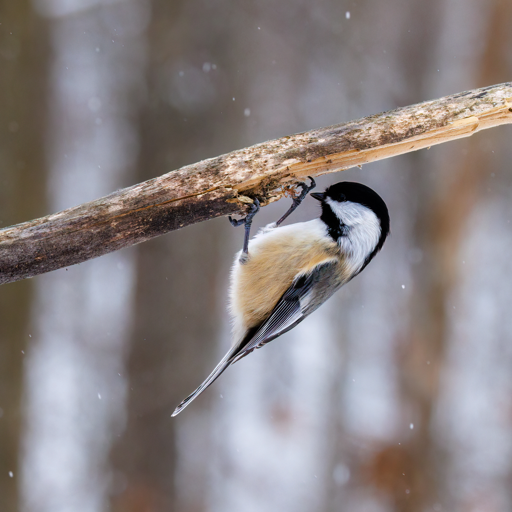

In [4]:
from utils import load_image

im = load_image('pexels-photo.jpeg', size=(512, 512))
im

In [5]:
from diffusers import AutoencoderKL
from torchvision.transforms import transforms
import torch
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(
    device)

# Encode the image

with torch.no_grad():
    tensor_im = transforms.ToTensor()(im).unsqueeze(0).to(device) * 2 - 1
    latent = vae.encode(tensor_im.half())  # Encode the image to a distribution
    latents = latent.latent_dist.sample()  # Sampling from the distribution
    latents = latents * 0.18215

latents.shape

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  hidden_states = F.scaled_dot_product_attention(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1279: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  hidden_states = F.scaled_dot_product_attention(


torch.Size([1, 4, 64, 64])

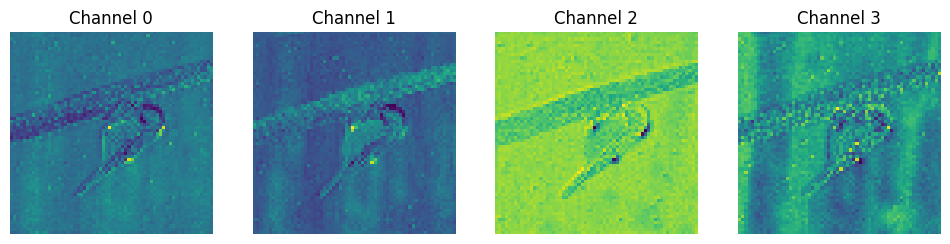

In [6]:
from utils import show_images

show_images([l for l in latents[0]], titles=[f'Channel {i}' for i in range(latents.shape[1])], ncols=4)

AttributeError: 'Axes' object has no attribute 'show'

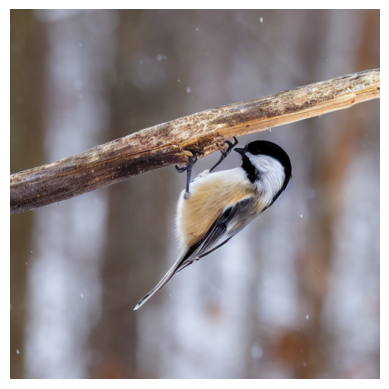

In [7]:
from utils import show_image

with torch.no_grad():
    image = vae.decode(latents / 0.18215).sample
    image = (image / 2 + 0.5).clamp(0, 1)

    #It will return a PIL Image
    image = show_image(image[0].float())

image